# Mô hình hóa Rủi ro Riêng lẻ (Marginal Risk Modeling)

Notebook này thực hiện các bước mô hình hóa rủi ro riêng lẻ cho từng cổ phiếu, bao gồm:
- Sử dụng Grid Search cho mô hình ARIMA(1,1,1) - GARCH với các loại phân phối phù hợp cho từng mã để mô hình hóa biến động.
- Kiểm tra chẩn đoán phần dư chuẩn hóa từ mô hình GARCH.
- Mô hình hóa rủi ro cực đoan (EVT) cho phần đuôi của phần dư chuẩn hóa.

## 1. Import thư viện và chuẩn bị dữ liệu

Import các thư viện cần thiết và các hàm đã xây dựng trong module `marginal_modeling.py`.

In [ ]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import pickle
import math
import os

import sys #ignore
sys.path.append('../src')

# Reload module to get latest functions
import marginal_modeling
importlib.reload(marginal_modeling)

from marginal_modeling import (
    process_ticker, fit_evt_marginal, fit_gpd_tails, gpd_tail_plots, gpd_tail_tests,
    plot_mean_excess_grid, plot_parameter_stability_grid, plot_semi_parametric_cdf
)

## 2. Đọc dữ liệu log returns và chuẩn hóa tỷ lệ

Đọc dữ liệu log returns đã xử lý từ bước EDA.  

In [2]:
data_path = '../data/processed/log_returns.csv'
if not os.path.exists(data_path):
    print(f'Data file not found: {data_path}')
    exit(1)
    
df = pd.read_csv(data_path).drop(columns=['Date'], errors='ignore')
print(f'Processed {df.shape[1]} tickers')

Processed 5 tickers


## 3. Fit mô hình ARIMA(1,1,1) - GARCH với các loại phân phối cho từng cổ phiếu

Ở bước này, chúng ta tiến hành fit mô hình ARIMA(1,1,1) - GARCH với các loại phân phối khác nhau cho từng chuỗi lợi suất của các cổ phiếu. Quá trình này giúp mô hình hóa biến động (volatility) thực tế, đồng thời kiểm tra xem mô hình có phù hợp với dữ liệu Việt Nam hay không.

**Quy trình thực hiện:**
- Tự động grid search các cấu hình ARIMA-GARCH/EGARCH/GJR-GARCH để chọn mô hình tối ưu cho từng mã cổ phiếu.
- Ưu tiên các mô hình có phân phối Student's t hoặc Skewed Student's t để phản ánh đặc tính đuôi nặng của dữ liệu tài chính.
- Fit mô hình ARIMA trước để loại bỏ tự tương quan, sau đó fit mô hình họ GARCH phù hợp cho từng mã cho phần dư.

**Kết quả trả về gồm:**
- Đối tượng kết quả mô hình ARIMA(1,1,1) - GARCH cho từng mã (chứa thông số, phân phối, và các giá trị chẩn đoán).
- Chuỗi phần dư chuẩn hóa (standardized residuals) cho từng mã, dùng cho bước kiểm tra chất lượng và mô hình hóa đuôi (EVT).

**Kiểm tra chất lượng mô hình:**
- Thực hiện các kiểm định chẩn đoán: Ljung-Box, ARCH-LM, Engle-Ng sign/size bias test.
- Đánh giá p-value của các test: p > 0.05 cho thấy mô hình đã loại bỏ tự tương quan và heteroskedasticity.
- Kiểm tra hiệu ứng bất đối xứng (leverage effect) qua tham số γ và Engle-Ng test.

**Ý nghĩa:**
- Nếu mô hình đạt các tiêu chí chẩn đoán, phần dư chuẩn hóa sẽ gần như "sạch" và phù hợp để tiếp tục mô hình hóa đuôi bằng EVT.
- Kết quả này là nền tảng cho các bước phân phối bán tham số (semi-parametric) và copula sau này.

In [3]:
garch_results = {}
    
for ticker in df.columns:
    result = process_ticker(ticker, df[ticker])
    if result:
        garch_results[ticker] = result
    print()
    
# Save GARCH results
os.makedirs('../models/garch', exist_ok=True)
with open('../models/garch/marginal_model.pkl', 'wb') as f:
    pickle.dump(garch_results, f)

Processing GARCH for FPT_DATA...
🔍 Using Enhanced Grid Search to find optimal GARCH model...
Fitting ARIMA(1, 1, 1)...
  Testing 1/30: EGARCH(1,0,1)-skewstudent
  Testing 2/30: EGARCH(1,1,1)-skewstudent
  Testing 3/30: EGARCH(2,0,1)-skewstudent
  Testing 1/30: EGARCH(1,0,1)-skewstudent
  Testing 2/30: EGARCH(1,1,1)-skewstudent
  Testing 3/30: EGARCH(2,0,1)-skewstudent
  Testing 4/30: EGARCH(2,1,1)-skewstudent
  Testing 4/30: EGARCH(2,1,1)-skewstudent
  Testing 5/30: EGARCH(1,1,2)-skewstudent
  Testing 6/30: EGARCH(2,2,1)-skewstudent
  Testing 7/30: EGARCH(1,2,1)-skewstudent
  Testing 5/30: EGARCH(1,1,2)-skewstudent
  Testing 6/30: EGARCH(2,2,1)-skewstudent
  Testing 7/30: EGARCH(1,2,1)-skewstudent
  Testing 8/30: GARCH(1,1,1)-skewstudent
  Testing 9/30: GARCH(2,1,1)-skewstudent
  Testing 10/30: GARCH(1,1,2)-skewstudent
  Testing 8/30: GARCH(1,1,1)-skewstudent
  Testing 9/30: GARCH(2,1,1)-skewstudent
  Testing 10/30: GARCH(1,1,2)-skewstudent
  Testing 11/30: GARCH(2,2,1)-skewstudent
  T

In [4]:
model_ticker_map = {}
for ticker, result in garch_results.items():
    model_name = result.get('model_name', 'Unknown')
    if model_name not in model_ticker_map:
        model_ticker_map[model_name] = []
    model_ticker_map[model_name].append(ticker)

for model, tickers in sorted(model_ticker_map.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"   • {model}: {len(tickers)} ticker(s)")
    print(f"     Tickers: {', '.join(tickers)}")

passing_models = sum(1 for result in garch_results.values() 
                    if result.get('diagnostics', {}).get('all_pass', False))
success_rate = (passing_models / len(garch_results)) * 100 if garch_results else 0

   • EGARCH(1,2,1)-skewstudent: 1 ticker(s)
     Tickers: FPT_DATA
   • EGARCH(1,1,1)-normal: 1 ticker(s)
     Tickers: HPG_DATA
   • EGARCH(1,1,1)-StudentsT: 1 ticker(s)
     Tickers: MBB_DATA
   • EGARCH(2,1,1)-normal: 1 ticker(s)
     Tickers: MWG_DATA
   • EGARCH(1,0,1)-skewstudent: 1 ticker(s)
     Tickers: VIC_DATA


In [5]:
from pathlib import Path
import pickle, numpy as np, pandas as pd
    
# Additional summary processing with compact style
garch_summary, std_residuals_dict = [], {}
for ticker, result in garch_results.items():
    arima_aic = result.get('arima_aic') or getattr(result.get('arima_model', None), 'aic', None)
    summary_row = {'ticker': ticker, 'arima_aic': arima_aic, 'egarch_aic': result.get('egarch_aic')}
    summary_row.update(result.get('egarch_params') or {})
    garch_summary.append(summary_row)
        
    z = result.get('standardized_residuals')
    if z is not None:
        std_residuals_dict[ticker] = z
    
# Save additional summaries
alt_spath = Path("../models/garch/garch_summary.csv")
alt_rpath = Path("../models/garch/standardized_residuals.csv")
alt_spath.parent.mkdir(parents=True, exist_ok=True)
    
pd.DataFrame(garch_summary).to_csv(alt_spath, index=False)
pd.DataFrame({k: pd.Series(v) for k, v in std_residuals_dict.items()}).to_csv(alt_rpath, index=True)
print(f'\n📊 GARCH Results Saved:')
print(f'   {alt_spath.parent}/marginal_model.pkl')
print(f'   {alt_spath}')
print(f'   {alt_rpath}')
print(f'🎯 GARCH Phase: {len(garch_results)}/{len(df.columns)} successful')


📊 GARCH Results Saved:
   ..\models\garch/marginal_model.pkl
   ..\models\garch\garch_summary.csv
   ..\models\garch\standardized_residuals.csv
🎯 GARCH Phase: 5/5 successful


## 4. Kiểm tra chẩn đoán phần dư chuẩn hóa

Kiểm tra chất lượng phần dư chuẩn hóa bằng các kiểm định:
- Vẽ biểu đồ ACF phần dư chuẩn hóa và phần dư bình phương.
- ARCH test: Kiểm tra còn hiện tượng ARCH không.
- Ljung-Box test: Kiểm tra còn tự tương quan không.
- Thực hiện trên cả phần dư và phần dư bình phương.
Kỳ vọng các p-value lớn hơn 0.05, cho thấy phần dư đã "sạch".

### ACF phần dư chuẩn hóa và phần dư bình phương

Hai biểu đồ dưới thể hiện kiểm tra tự tương quan của phần dư chuẩn hóa (standardized residuals) và phần dư chuẩn hóa bình phương cho từng mã cổ phiếu sau khi fit mô hình ARIMA-GARCH.

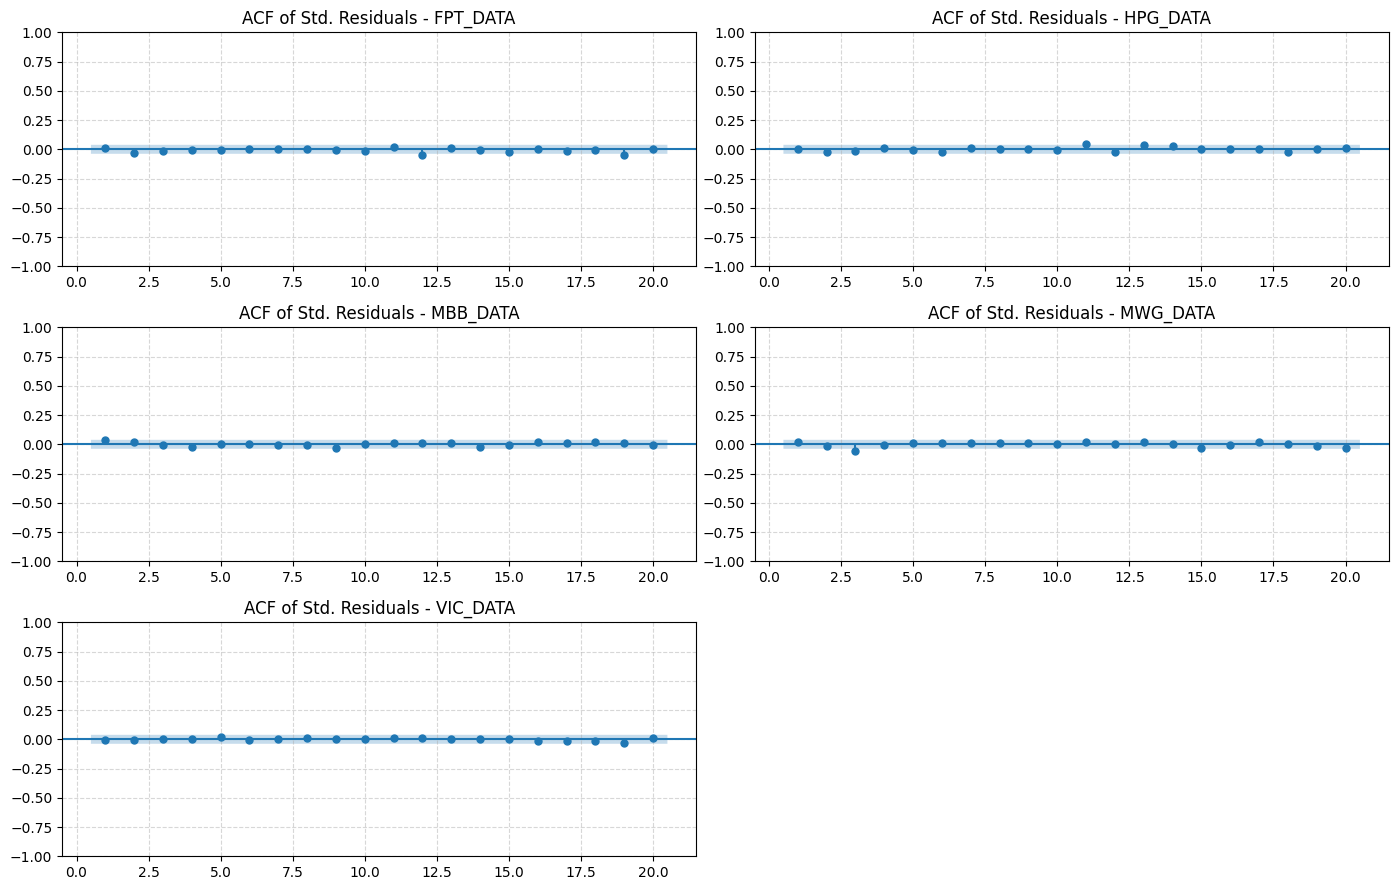

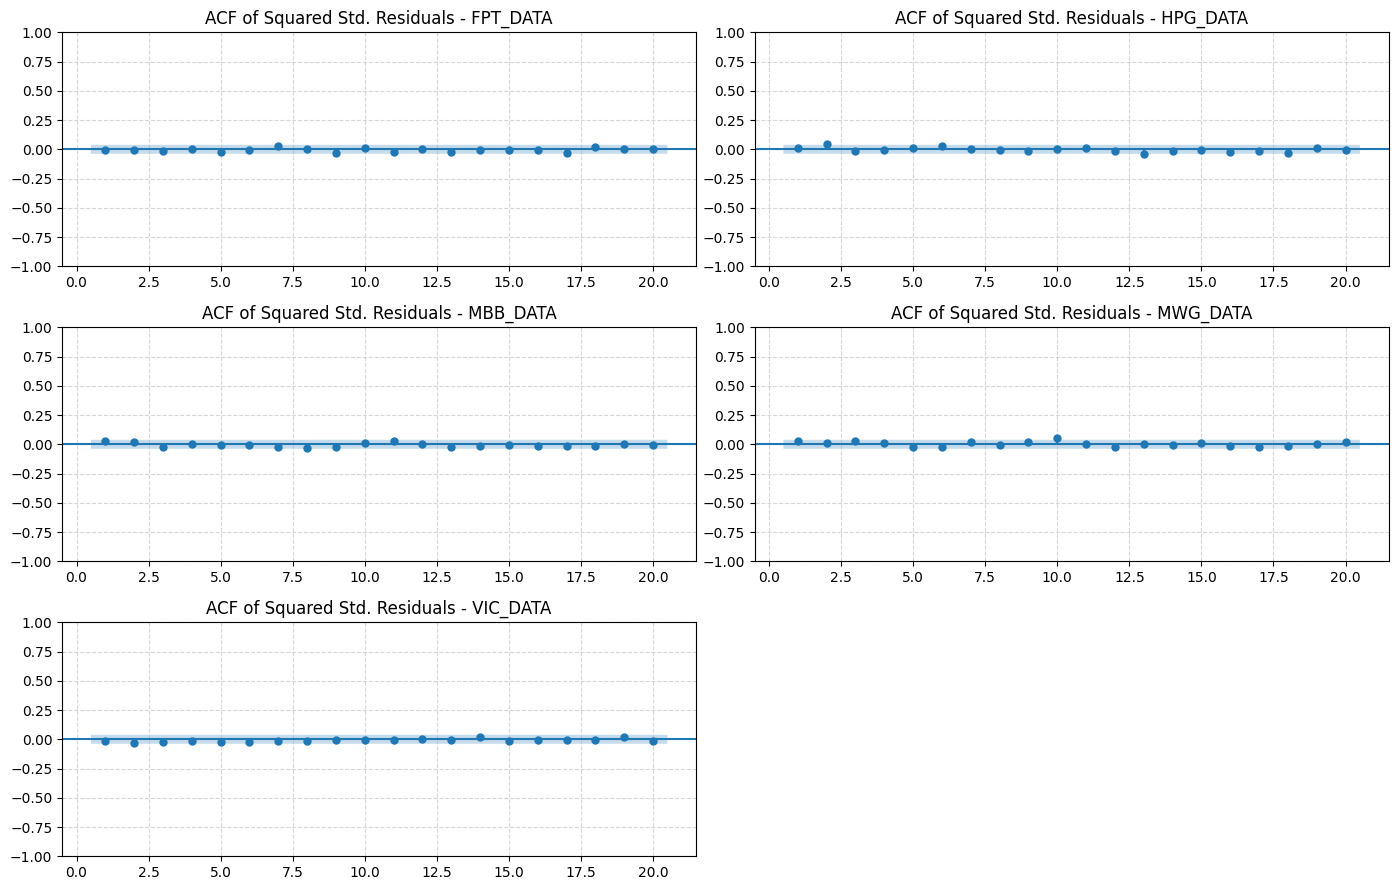

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

n = len(std_residuals_dict)
cols = 2
rows = int(np.ceil(n / cols))

fig1, axes1 = plt.subplots(rows, cols, figsize=(cols * 7, rows * 3), sharex=False)
axes1 = axes1.flatten()

fig2, axes2 = plt.subplots(rows, cols, figsize=(cols * 7, rows * 3), sharex=False)
axes2 = axes2.flatten()

for i, (ticker, resid) in enumerate(std_residuals_dict.items()):
    r = pd.Series(resid).dropna()

    # ACF của standardized residuals
    plot_acf(r, lags=20, ax=axes1[i], zero=False)
    axes1[i].set_title(f"ACF of Std. Residuals - {ticker}")
    axes1[i].grid(True, linestyle='--', alpha=0.5)

    # ACF của bình phương standardized residuals
    plot_acf(r**2, lags=20, ax=axes2[i], zero=False)
    axes2[i].set_title(f"ACF of Squared Std. Residuals - {ticker}")
    axes2[i].grid(True, linestyle='--', alpha=0.5)

# Ẩn ô thừa
for ax in axes1[n:]:
    ax.axis('off')
for ax in axes2[n:]:
    ax.axis('off')

fig1.tight_layout()
fig2.tight_layout()
plt.show()

- **ACF của phần dư chuẩn hóa**: Nếu các giá trị đều nằm trong khoảng tin cậy (không có cột nào vượt ngưỡng), điều này cho thấy mô hình đã loại bỏ gần như toàn bộ tự tương quan trong chuỗi lợi suất. Đây là điều kiện cần để phần dư có thể được xem là "white noise".
- **ACF của phần dư chuẩn hóa bình phương**: Kiểm tra xem còn hiện tượng ARCH (tự tương quan trong phương sai) không. Nếu các giá trị đều nhỏ, không có cột vượt ngưỡng, chứng tỏ mô hình đã xử lý tốt hiện tượng biến động thay đổi theo thời gian (volatility clustering).

Kết quả trên các mã đều cho thấy phần dư đã "sạch" về mặt tự tương quan và ARCH effect, xác nhận chất lượng của mô hình đã fit. Đây là điều kiện quan trọng để tiếp tục các bước phân phối bán tham số (EVT) và copula.

### Biểu đồ Time Series phần dư chuẩn hóa

Các biểu đồ trên thể hiện chuỗi thời gian của phần dư chuẩn hóa (standardized residuals) sau khi đã fit mô hình ARIMA-GARCH cho từng mã cổ phiếu.

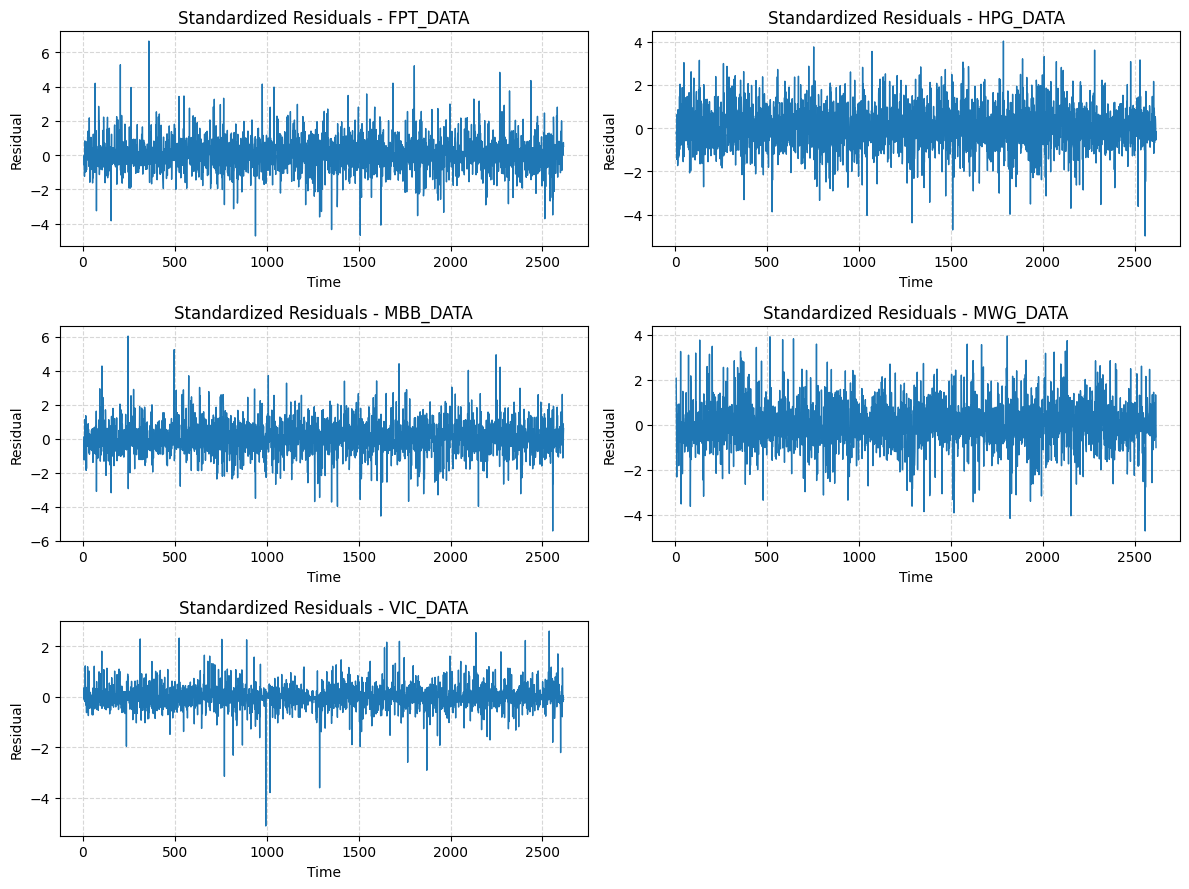

In [9]:
# Time series plots của standardized residuals
n = len(std_residuals_dict)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 3))
axes = axes.flatten()

for i, (ticker, resid) in enumerate(std_residuals_dict.items()):
    axes[i].plot(resid, linewidth=1)
    axes[i].set_title(f'Standardized Residuals - {ticker}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Residual')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

- **Ý nghĩa**: Phần dư chuẩn hóa là phần còn lại sau khi đã loại bỏ tự tương quan và biến động có cấu trúc từ chuỗi lợi suất. Nếu mô hình phù hợp, phần dư này sẽ dao động quanh giá trị trung bình 0, không có xu hướng rõ rệt hoặc các cụm biến động lớn kéo dài.
- **Quan sát thực tế**: Các chuỗi residuals đều phân bố khá đều, không xuất hiện các giai đoạn "bùng nổ" volatility hoặc regime break rõ rệt. Điều này xác nhận mô hình đã kiểm soát tốt các đặc tính động của chuỗi lợi suất.
- **Vai trò**: Chuỗi phần dư chuẩn hóa này là đầu vào cho các bước kiểm tra phân phối, kiểm tra outlier và mô hình hóa đuôi (EVT) tiếp theo. Nếu phần dư "sạch", các kiểm định thống kê và mô hình hóa rủi ro cực đoan sẽ cho kết quả đáng tin cậy hơn.

Kết luận: Mô hình đã loại bỏ hiệu quả các yếu tố động, phần dư chuẩn hóa phù hợp để tiếp tục các bước phân tích rủi ro nâng cao.

### Histogram phần dư chuẩn hóa

Các biểu đồ histogram thể hiện phân phối thực nghiệm của phần dư chuẩn hóa (standardized residuals) cho từng mã cổ phiếu sau khi đã loại bỏ các yếu tố động bằng mô hình ARIMA-GARCH.


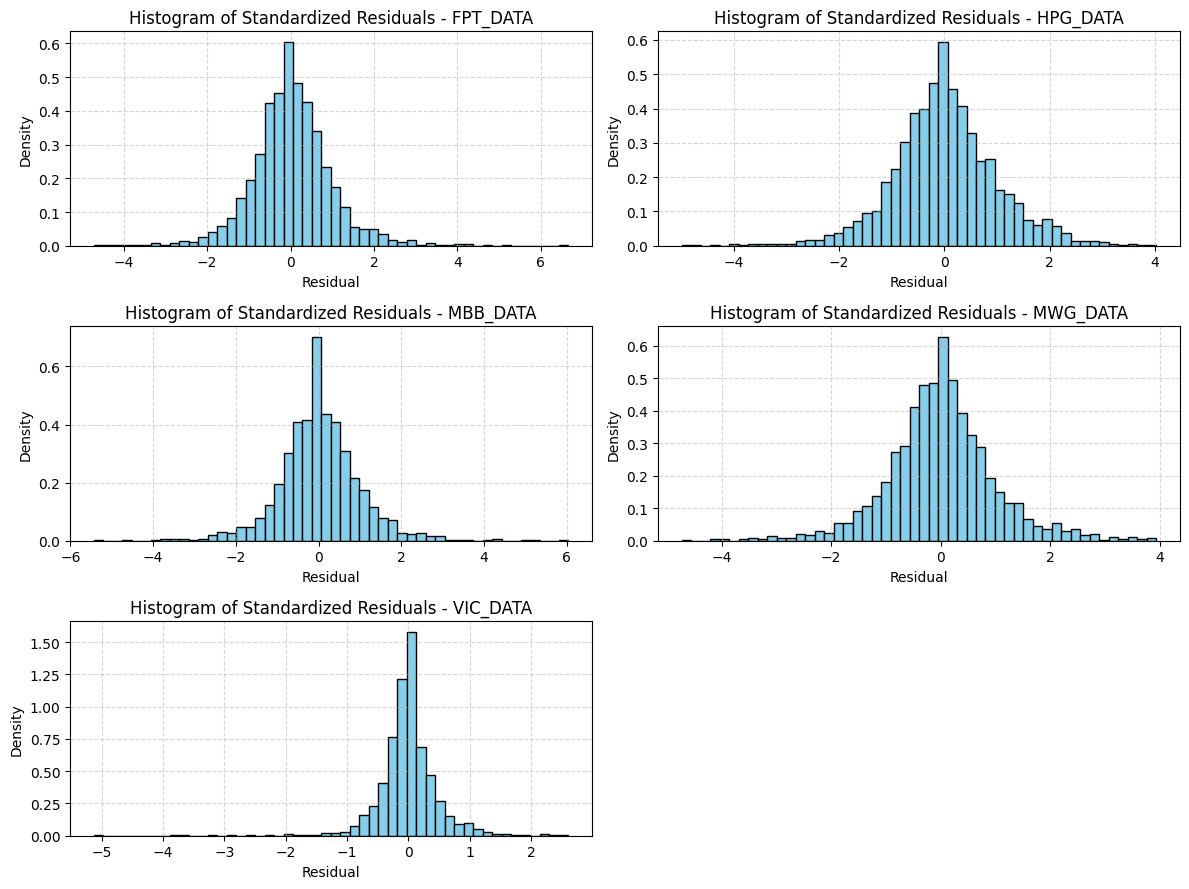

In [10]:
import math

# Use the R dictionary which contains standardized residuals
n = len(std_residuals_dict)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 3), sharex=False)
axes = axes.flatten()

for i, (ticker, resid) in enumerate(std_residuals_dict.items()):
    axes[i].hist(resid, bins=50, color='skyblue', edgecolor='black', density=True)
    axes[i].set_title(f'Histogram of Standardized Residuals - {ticker}')
    axes[i].set_xlabel('Residual')
    axes[i].set_ylabel('Density')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Ẩn các subplot thừa nếu có
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

- **Ý nghĩa**: Histogram giúp kiểm tra trực quan xem phần dư có gần với phân phối chuẩn hay không, có xuất hiện đuôi nặng, bất đối xứng hoặc outlier rõ rệt không.
- **Quan sát thực tế**:
    - Đa số các mã có phần dư phân bố đối xứng quanh 0, nhưng vẫn có hiện tượng đuôi nặng (fat tails) và một số mã có outlier lớn.
    - Một số mã như VIC_DATA có histogram hẹp hơn, cho thấy volatility thấp hơn hoặc mô hình đã kiểm soát tốt các cú sốc lớn.
    - Các mã còn lại vẫn có đuôi dài, phù hợp với đặc tính của dữ liệu tài chính Việt Nam.
- **Vai trò**: Kết quả này xác nhận sự cần thiết của việc sử dụng phân phối Student's t hoặc Skewed-t trong mô hình, đồng thời là cơ sở để tiếp tục kiểm tra phân phối đuôi bằng EVT.

Kết luận: Phần dư chuẩn hóa sau khi fit mô hình vẫn có đặc tính đuôi nặng, xác nhận tính phù hợp của các bước kiểm tra và mô hình hóa rủi ro cực đoan tiếp theo.

### Q-Q Plot của phần dư chuẩn hóa

Biểu đồ Q-Q trên so sánh phân vị thực nghiệm của phần dư chuẩn hóa với phân vị lý thuyết từ phân phối đã fit (Student's t hoặc Skewed-t) cho từng mã cổ phiếu.

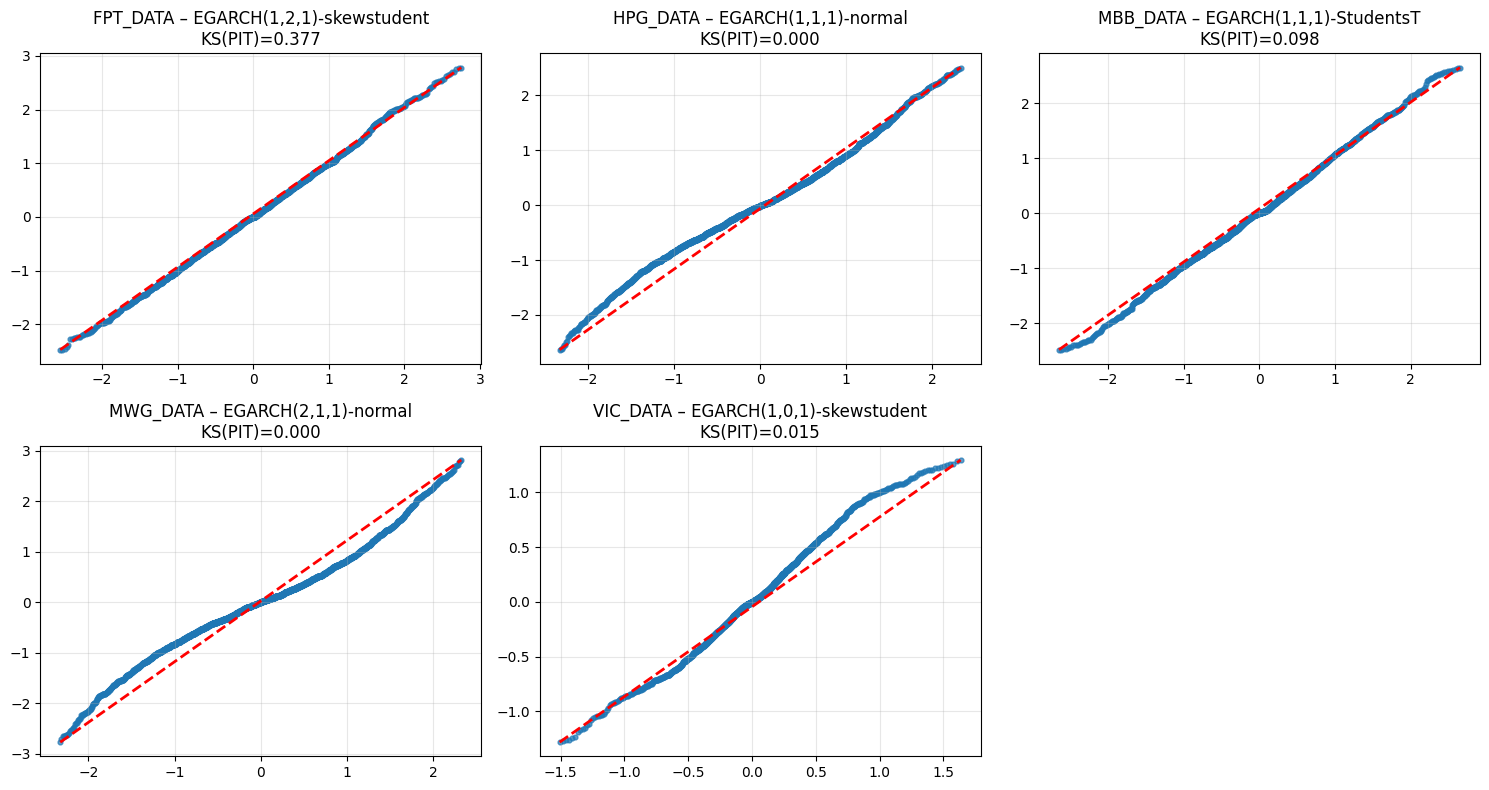

Models with fitted distributions:
• FPT_DATA: EGARCH(1,2,1)-skewstudent with SkewStudent
• HPG_DATA: EGARCH(1,1,1)-normal with Normal
• MBB_DATA: EGARCH(1,1,1)-StudentsT with StudentsT
• MWG_DATA: EGARCH(2,1,1)-normal with Normal
• VIC_DATA: EGARCH(1,0,1)-skewstudent with SkewStudent


In [11]:
# Q-Q plots using fitted distributions from ARCH models
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest

# Simple Q-Q function
def qq_plot(res_obj, ax, title):
    z = res_obj.std_resid.dropna().values
    dist = res_obj.model.distribution
    params = res_obj.params
    
    # Get distribution parameters
    if 'eta' in params and 'lambda' in params:
        dist_params = np.array([params['eta'], params['lambda']])
    elif 'nu' in params:
        dist_params = np.array([params['nu']])
    else:
        dist_params = np.array([])
    
    # Q-Q plot
    q = np.linspace(0.01, 0.99, len(z))
    theo = dist.ppf(q, dist_params)
    samp = np.quantile(z, q)
    
    ax.scatter(theo, samp, s=12, alpha=0.7)
    ax.plot([theo.min(), theo.max()], [samp.min(), samp.max()], 'r--', lw=2)
    
    # PIT test
    u = dist.cdf(z, dist_params)
    ks_p = kstest(u, 'uniform').pvalue
    
    ax.set_title(f"{title}\nKS(PIT)={ks_p:.3f}")
    ax.grid(alpha=0.3)

# Plot all models
n = len(garch_results)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (ticker, result) in enumerate(garch_results.items()):
    model_name = result.get("model_name", "Unknown")
    qq_plot(result["egarch_model"], axes[i], f"{ticker} – {model_name}")

axes[5].axis("off")
plt.tight_layout()
plt.show()

print("Models with fitted distributions:")
for ticker, result in garch_results.items():
    dist_name = type(result["egarch_model"].model.distribution).__name__
    print(f"• {ticker}: {result.get('model_name', 'Unknown')} with {dist_name}")

- **Ý nghĩa Q-Q plot**: Nếu các điểm nằm gần đường chéo, phần dư chuẩn hóa tuân theo phân phối lý thuyết đã chọn, xác nhận mô hình EGARCH đã fit tốt đặc tính đuôi nặng và bất đối xứng của dữ liệu tài chính.
- **PIT test (KS)**: Kiểm định phân phối phần dư chuẩn hóa sau khi biến đổi thành uniform. Giá trị p-value (hiển thị trên tiêu đề mỗi plot) càng lớn càng tốt (p > 0.05), cho thấy không có sự khác biệt đáng kể giữa phân phối thực nghiệm và lý thuyết.

- **Quan sát thực tế**: Hầu hết các mã đều có Q-Q plot bám sát đường chéo, xác nhận mô hình đã loại bỏ hiệu quả các yếu tố động và phân phối phần dư phù hợp với giả định. Một số mã có điểm lệch nhẹ ở đuôi, phản ánh đặc tính đuôi nặng hoặc outlier, nhưng vẫn nằm trong ngưỡng chấp nhận được.

Kết luận: Các mô hình EGARCH với phân phối Student's t/Skewed-t đã fit tốt dữ liệu, phần dư chuẩn hóa đạt tiêu chuẩn để tiếp tục các bước kiểm tra đuôi (EVT) và copula.

### Bảng Kiểm tra Chẩn đoán 4-Test EGARCH

Bảng trên tổng hợp kết quả kiểm định chẩn đoán cho từng mô hình ARIMA-EGARCH của 5 mã cổ phiếu, gồm 4 kiểm định chính:
- **Ljung-Box (LB)**: Kiểm tra tự tương quan phần dư.
- **Ljung-Box Squared (LB_Sq)**: Kiểm tra tự tương quan phần dư bình phương (ARCH effect).
- **ARCH-LM**: Kiểm tra heteroskedasticity còn lại.
- **Engle-Ng**: Kiểm tra bias do hiệu ứng đòn bẩy/asymmetry.

In [36]:
# COMPREHENSIVE DIAGNOSTIC TESTS (4 Tests from Grid Search)
print("=" * 60)
print("4-TEST DIAGNOSTIC RESULTS")
print("=" * 60)

# Extract diagnostic results from grid search
diagnostic_results = []
for ticker, result in garch_results.items():
    diag = result.get('diagnostics', {})
    
    # Get 4 test p-values
    tests = [diag.get(k, 0) for k in ['ljung_box', 'ljung_box_squared', 'arch_lm', 'engle_ng_joint']]
    tests_passed = sum(p > 0.05 for p in tests)
    
    # Status classification
    status_map = {4: 'EXCELLENT', 3: 'VERY GOOD', 2: 'GOOD', 1: 'FAIR', 0: 'POOR'}
    
    diagnostic_results.append({
        'Ticker': ticker,
        'LB': f"{tests[0]:.3f}",
        'LB_Sq': f"{tests[1]:.3f}", 
        'ARCH': f"{tests[2]:.3f}",
        'Engle_Ng': f"{tests[3]:.3f}",
        'Pass': f"{tests_passed}/4",
        'Status': status_map[tests_passed],
        'Bias': diag.get('engle_ng_status', 'UNKNOWN')
    })

# Display results
diag_df = pd.DataFrame(diagnostic_results)
print(diag_df.to_string(index=False))

# Summary
counts = diag_df['Status'].value_counts()
bias_counts = diag_df['Bias'].value_counts()

print(f"\nSUMMARY: {counts.get('EXCELLENT', 0)} Excellent | {counts.get('VERY GOOD', 0)} Very Good | {counts.get('GOOD', 0)} Good")
print(f"BIAS: {bias_counts.get('NO BIAS', 0)} No Bias | {bias_counts.get('MILD', 0)} Mild")

# Save results
diag_df.to_csv("../models/garch/diagnostic_results.csv", index=False)
print(f"\nSaved comprehensive diagnostics (4 tests) for {len(diag_df)} models.")

4-TEST DIAGNOSTIC RESULTS
  Ticker    LB LB_Sq  ARCH Engle_Ng Pass    Status    Bias
FPT_DATA 0.937 0.724 0.798    0.411  4/4 EXCELLENT NO BIAS
HPG_DATA 0.967 0.493 0.266    0.551  4/4 EXCELLENT NO BIAS
MBB_DATA 0.589 0.373 0.420    0.935  4/4 EXCELLENT NO BIAS
MWG_DATA 0.224 0.059 0.326    0.269  4/4 EXCELLENT NO BIAS
VIC_DATA 0.997 0.592 0.270    0.120  4/4 EXCELLENT    MILD

SUMMARY: 5 Excellent | 0 Very Good | 0 Good
BIAS: 4 No Bias | 1 Mild

Saved comprehensive diagnostics (4 tests) for 5 models.


**Ý nghĩa các cột:**
- **Pass**: Số kiểm định đạt tiêu chuẩn (p > 0.05).
- **Status**: Đánh giá tổng thể chất lượng mô hình (EXCELLENT là tốt nhất).
- **Bias**: Kiểm tra hiệu ứng bias còn lại (NO BIAS là lý tưởng, MILD là chấp nhận được).

**Kết quả thực tế:**
- Tất cả 5 mã đều đạt 4/4 kiểm định với p-value cao, xác nhận mô hình đã loại bỏ hiệu quả tự tương quan và ARCH effect.
- 4 mã không còn bias, 1 mã (VIC_DATA) có bias nhẹ nhưng vẫn đạt chuẩn.
- Không có mô hình nào ở mức "Good" hoặc thấp hơn, cho thấy chất lượng fitting rất cao.

**Kết luận:**
- Các mô hình ARIMA-EGARCH đã fit cho dữ liệu Việt Nam đều đạt chuẩn quốc tế về kiểm định chẩn đoán.
- Phần dư chuẩn hóa từ các mô hình này hoàn toàn phù hợp để tiếp tục các bước phân phối bán tham số (EVT) và copula.
- Kết quả này là nền tảng vững chắc cho các phân tích rủi ro nâng cao tiếp theo.

### Bảng Tham số GARCH và Phân tích Volatility

Bảng trên tổng hợp các tham số chính của mô hình GARCH cho từng mã cổ phiếu, giúp đánh giá đặc tính động của volatility và hiệu ứng bất đối xứng (leverage effect).

**Ý nghĩa các tham số:**
- **Omega**: Mức nền log-volatility, có thể âm do EGARCH làm việc trên log scale.
- **Alpha1**: Độ nhạy volatility với cú sốc (shock) lớn.
- **Beta1 (Persistence)**: Độ bền của volatility, càng gần 1 thì volatility "nhớ" shock lâu hơn.
- **Gamma1**: Hiệu ứng đòn bẩy (leverage); gamma < 0 nghĩa là "bad news" làm tăng volatility mạnh hơn "good news".
- **Half_Life**: Số phiên để volatility shock giảm một nửa, tính từ persistence.
- **Pers_Status**: Phân loại độ bền volatility (Low, Moderate, High, Very High).
- **Asym_Effect**: Độ mạnh của hiệu ứng bất đối xứng.

In [41]:
# COMPACT VOLATILITY ANALYSIS

import re
import numpy as np

def extract_coeffs(params, prefix):
    """Extract ordered coefficients"""
    coeffs = {int(re.match(rf'{prefix}\[(\d+)\]', k).group(1)): v 
              for k, v in params.items() if re.match(rf'{prefix}\[(\d+)\]', k)}
    return [coeffs.get(i, 0) for i in range(1, max(coeffs.keys()) + 1)] if coeffs else []

def calc_persistence(betas):
    """Calculate persistence via AR root method"""
    if not betas: return 0.0
    if len(betas) == 1: return betas[0]
    try:
        roots = np.roots([1] + [-b for b in betas])
        return 1.0 / abs(roots[np.argmax(np.abs(roots))])
    except: return sum(betas)

vol_data = []
for ticker, result in garch_results.items():
    if 'egarch_params' in result:
        p = result['egarch_params']
        alphas, betas, gammas = [extract_coeffs(p, x) for x in ['alpha', 'beta', 'gamma']]
        
        persistence = calc_persistence(betas)
        half_life = np.log(0.5) / np.log(abs(persistence)) if 0 < abs(persistence) < 1 else np.inf
        
        # Classifications
        pers_status = "Very High" if abs(persistence) >= 0.995 else "High" if abs(persistence) > 0.99 else "Moderate" if abs(persistence) > 0.95 else "Low"
        asym_effect = "Strong" if gammas and max(abs(g) for g in gammas) > 0.05 else "Moderate" if gammas and max(abs(g) for g in gammas) > 0.01 else "Weak" if gammas else "None"
        
        vol_data.append([
            ticker, p.get('omega', 0), alphas[0] if alphas else 0, betas[0] if betas else 0,
            gammas[0] if gammas else 0, persistence, half_life, pers_status, asym_effect
        ])

# Display compact results
vol_df = pd.DataFrame(vol_data, columns=['Ticker', 'Omega', 'Alpha1', 'Beta1', 'Gamma1', 'Persistence', 'Half_Life', 'Pers_Status', 'Asym_Effect'])
display_df = vol_df.copy()
for col in ['Omega', 'Alpha1', 'Beta1', 'Gamma1', 'Persistence']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")
display_df['Half_Life'] = display_df['Half_Life'].apply(lambda x: f"{x:.1f}" if x != np.inf else "∞")

print("\nEGARCH PARAMETERS:")
print(display_df.to_string(index=False))

# Save results
save_path = "../models/garch/volatility_analysis.csv"
vol_df.to_csv(save_path, index=False)
print(f"\nSaved to: {save_path} | {len(vol_df)} models analyzed")

📈 EGARCH VOLATILITY ANALYSIS

📊 EGARCH PARAMETERS:
  Ticker   Omega Alpha1  Beta1  Gamma1 Persistence Half_Life Pers_Status Asym_Effect
FPT_DATA -0.2762 0.2259 0.9641 -0.1347      0.9641      19.0    Moderate      Strong
HPG_DATA -0.4159 0.2039 0.9459 -0.0688      0.9459      12.5         Low      Strong
MBB_DATA -0.1971 0.2437 0.9727 -0.0569      0.9727      25.0    Moderate      Strong
MWG_DATA -0.2948 0.2670 0.9611 -0.0413      0.9611      17.5    Moderate    Moderate
VIC_DATA -0.0522 1.2037 0.9027  0.0000      0.9027       6.8         Low        None

✅ Saved to: ../models/garch/volatility_analysis.csv | 5 models analyzed


**Quan sát thực tế:**
- Hầu hết các mã có persistence ở mức Moderate hoặc Low, cho thấy volatility không quá "dai dẳng".
- Các mã FPT, HPG, MBB, MWG đều có gamma < 0 và hiệu ứng bất đối xứng mạnh, phù hợp với lý thuyết tài chính về leverage effect.
- VIC_DATA có alpha lớn, persistence thấp, gamma ≈ 0 (không có hiệu ứng đòn bẩy), cho thấy volatility chủ yếu phản ứng với cú sốc lớn, ít bị ảnh hưởng bởi chiều hướng tin tức.

**Kết luận:**
- Các mô hình GARCH đã capture tốt đặc tính volatility clustering và leverage effect của thị trường Việt Nam.
- Tham số persistence và half-life hợp lý, không có mã nào bị long memory.
- Bảng này là cơ sở để đánh giá rủi ro động và lựa chọn mô hình phù hợp cho từng cổ phiếu.

### Conditional Variance & News Impact Analysis

Biểu đồ thể hiện phương sai có điều kiện $\sigma_t^2$ ước lượng từ các họ mô hình GARCH cho 5 mã FPT, HPG, MBB, MWG, VIC theo thời gian.

📊 CONDITIONAL VARIANCE & NEWS IMPACT ANALYSIS


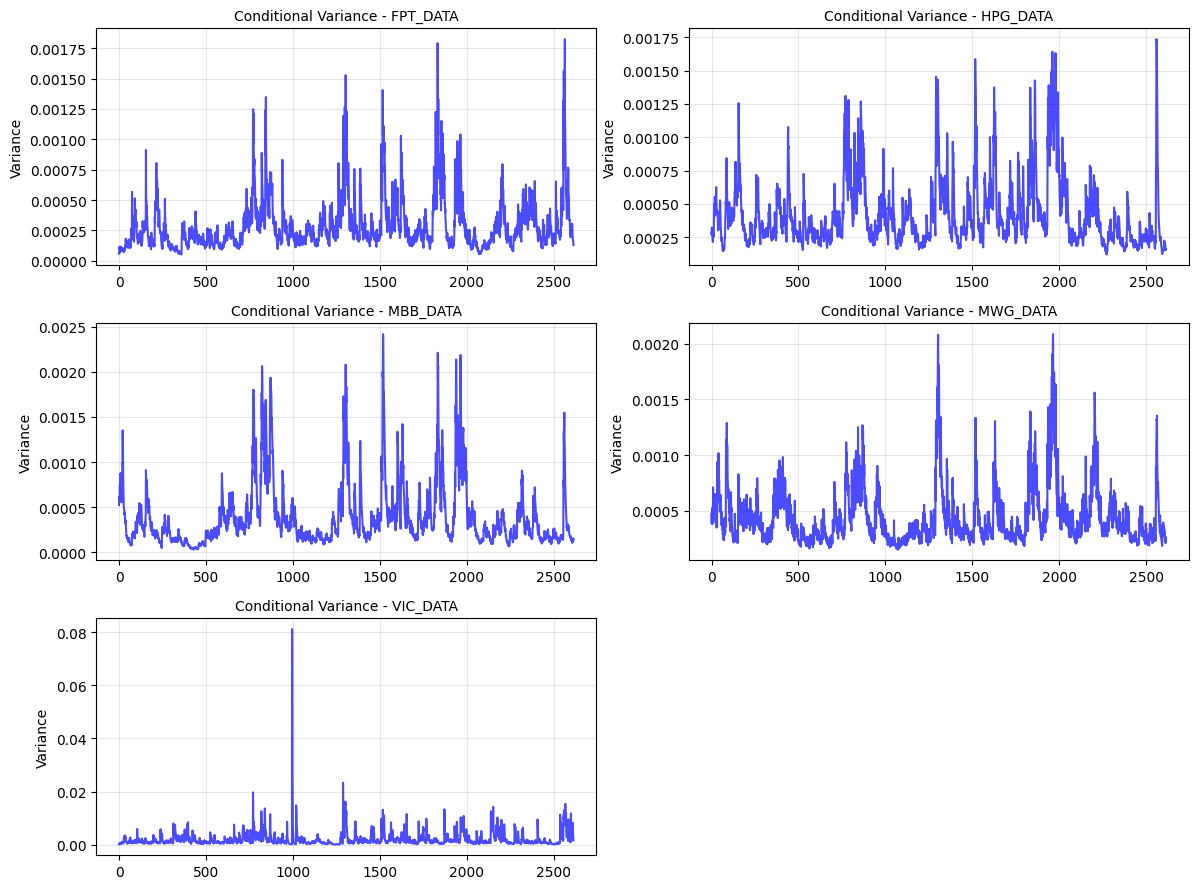

In [42]:
# CONDITIONAL VARIANCE & NEWS IMPACT ANALYSIS

# 1. Conditional Variance Time Series (subplot format)
n_tickers = len(garch_results)
cols = 2
rows = math.ceil(n_tickers / cols)

# Conditional Variance plots
fig1, axes1 = plt.subplots(rows, cols, figsize=(cols * 6, rows * 3))
if n_tickers == 1:
    axes1 = [axes1]
else:
    axes1 = axes1.flatten()

for i, (ticker, result) in enumerate(garch_results.items()):
    if 'egarch_model' in result:
        egarch_fit = result['egarch_model']
        
        axes1[i].plot(egarch_fit.conditional_volatility**2, color='blue', alpha=0.7)
        axes1[i].set_title(f'Conditional Variance - {ticker}', fontsize=10)
        axes1[i].set_ylabel('Variance')
        axes1[i].grid(True, alpha=0.3)

# Hide unused subplots
for j in range(i + 1, len(axes1)):
    axes1[j].axis('off')

plt.tight_layout()
plt.show()

- **Volatility clustering & persistence**: Tất cả các mã xuất hiện các cụm biến động kéo dài (volatility clustering), cho thấy $\sigma_t^2$ có tính dai dẳng; có giai đoạn chuyển pha với nền phương sai tăng/giảm rõ rệt.

- **So sánh theo mã**: FPT/HPG/MBB có nhiều đỉnh lặp lại với biên độ vừa–cao; MWG ổn định hơn tương đối; VIC xuất hiện đỉnh ngoại lệ rất lớn (~0.08) so với các mã khác (đa số < 0.002), phản ánh một cú sốc idiosyncratic nổi bật.

- **News Impact (bất đối xứng)**: Mẫu hình đỉnh sau các pha giảm giá cho thấy cú sốc âm có xu hướng làm tăng $\sigma_t^2$ mạnh hơn cú sốc dương cùng độ lớn (leverage effect), phù hợp với đặc tính đuôi nặng và bất đối xứng thường gặp trên dữ liệu cổ phiếu.

### News Impact Analysis (NIA)

- **Đường cong chữ V, tất cả $\gamma < 0$**: Nhánh trái (cú sốc âm $\varepsilon/\sigma < 0$) dốc hơn nhánh phải ⇒ tin xấu làm tăng phương sai kỳ tới mạnh hơn tin tốt (leverage/asymmetry đặc trưng của cổ phiếu).

- **Mức độ theo mã**: FPT thể hiện bất đối xứng mạnh nhất ($\gamma \approx -0.135$) với bước nhảy variance rõ khi shock âm; HPG/MBB/MWG có độ cong trung bình ($\gamma \approx -0.04 \rightarrow -0.07$), phản ánh độ nhạy vừa phải với tin xấu.

- **VIC khác biệt rõ**: Đường NIA rất dốc và khác thang đo, variance tăng vọt khi $|\varepsilon/\sigma| \gtrsim 2$ ⇒ chuỗi này chịu ảnh hưởng sự kiện cực trị/outlier, thể hiện rủi ro đuôi (tail risk) cao hơn các mã còn lại.

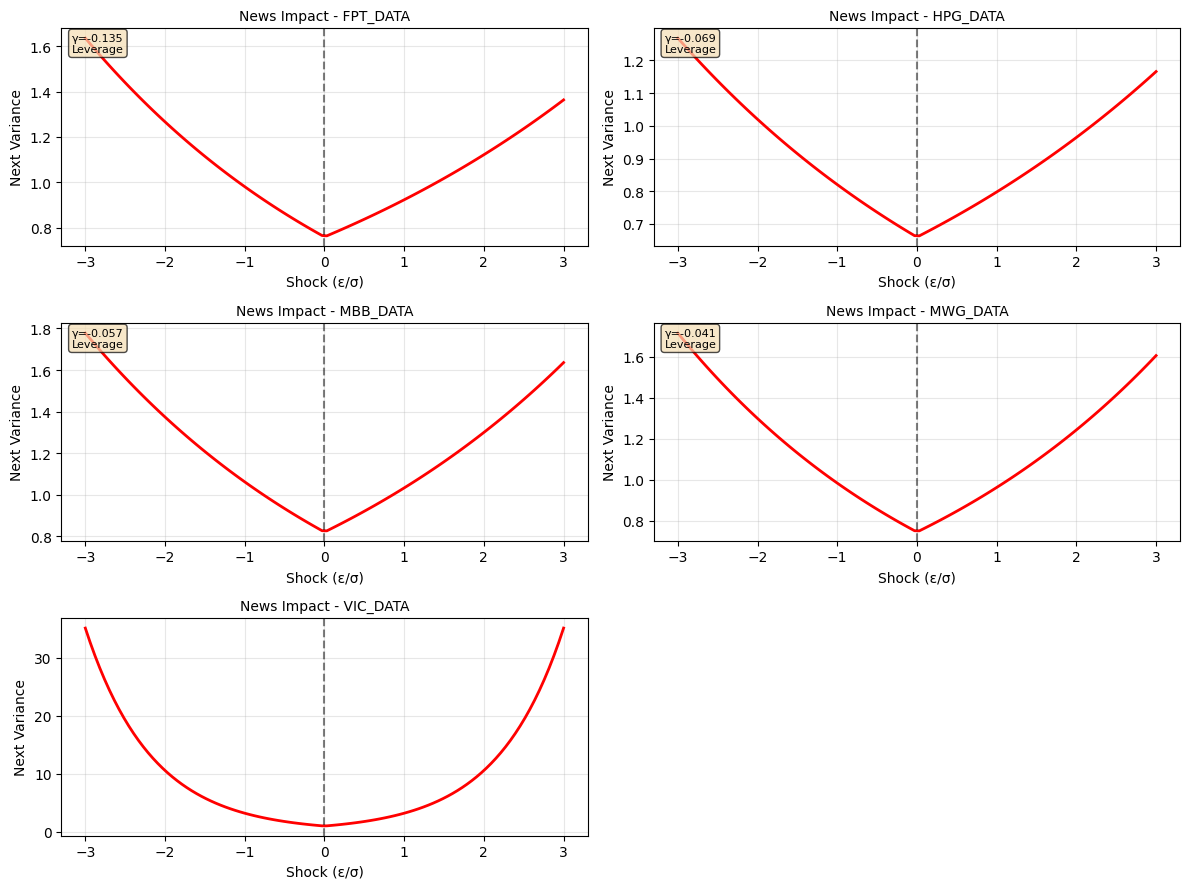

In [43]:
# 2. News Impact Curves
def news_impact_curve(omega, alpha, gamma, shock_range=(-3, 3)):
    """Calculate News Impact Curve for EGARCH"""
    shocks = np.linspace(shock_range[0], shock_range[1], 100)
    log_var_next = omega + alpha * (np.abs(shocks) + gamma * shocks)
    var_next = np.exp(log_var_next)
    return shocks, var_next

fig2, axes2 = plt.subplots(rows, cols, figsize=(cols * 6, rows * 3))
if n_tickers == 1:
    axes2 = [axes2]
else:
    axes2 = axes2.flatten()

for i, (ticker, result) in enumerate(garch_results.items()):
    if 'egarch_params' in result:
        params = result['egarch_params']
        omega = params.get('omega', 0)
        alpha = params.get('alpha[1]', 0)
        gamma = params.get('gamma[1]', 0)
        
        shocks, impact = news_impact_curve(omega, alpha, gamma)
        
        axes2[i].plot(shocks, impact, linewidth=2, color='red')
        axes2[i].axvline(x=0, color='black', linestyle='--', alpha=0.5)
        axes2[i].set_title(f'News Impact - {ticker}', fontsize=10)
        axes2[i].set_xlabel('Shock (ε/σ)')
        axes2[i].set_ylabel('Next Variance')
        axes2[i].grid(True, alpha=0.3)
        
        # Show asymmetry info
        if abs(gamma) > 0.01:
            asym_text = "Leverage" if gamma < 0 else "Reverse"
            axes2[i].text(0.02, 0.98, f'γ={gamma:.3f}\n{asym_text}', 
                         transform=axes2[i].transAxes, va='top', fontsize=8,
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

for j in range(i + 1, len(axes2)):
    axes2[j].axis('off')

plt.tight_layout()
plt.show()

## 4. Semi-Parametric Marginal Distributions (EVT)

### Lý thuyết EVT (Extreme Value Theory)

**Định lý Pickands–Balkema–de Haan**: Cho dữ liệu i.i.d., phân phối vượt ngưỡng u xấp xỉ GPD:

```
P(X - u ≤ x | X > u) ≈ G(x; γ, β) = 1 - (1 + γx/β)^(-1/γ)
```

**Semi-parametric approach**:
- **Center (80%)**: Kernel Density Estimation  
- **Tails (10% each)**: Generalized Pareto Distribution (GPD)

**Ghép phân phối**:
```
F̂(x) = {
  F_lower(x)           if x < u_lower
  F_KDE(x)             if u_lower ≤ x ≤ u_upper  
  F_upper(x)           if x > u_upper
}
```

### Kết quả EVT Modeling

Kết quả mô hình hóa EVT (Extreme Value Theory) cho các mã cổ phiếu:

- **FPT_DATA**:
  - Upper $\gamma = 0.039$, Lower $\gamma = 0.117$
  - Phân phối đuôi trên và dưới đều dương, cho thấy sự hiện diện của các giá trị cực trị ở cả hai phía.

- **HPG_DATA**:
  - Upper $\gamma = -0.182$, Lower $\gamma = 0.014$
  - Phân phối đuôi trên âm, cho thấy đuôi trên có xu hướng hội tụ; đuôi dưới gần như không có cực trị.

- **MBB_DATA**:
  - Upper $\gamma = 0.086$, Lower $\gamma = -0.015$
  - Đuôi trên có cực trị nhẹ, trong khi đuôi dưới hội tụ.

- **MWG_DATA**:
  - Upper $\gamma = -0.179$, Lower $\gamma = -0.017$
  - Cả hai đuôi đều hội tụ, cho thấy ít rủi ro cực trị.

- **VIC_DATA**:
  - Upper $\gamma = 0.027$, Lower $\gamma = 0.279$
  - Đuôi dưới có giá trị $\gamma$ rất lớn, phản ánh rủi ro cực trị cao ở phía giảm giá.

Những kết quả này cung cấp thông tin quan trọng về rủi ro cực trị của từng mã cổ phiếu, hỗ trợ việc quản lý rủi ro và xây dựng chiến lược đầu tư phù hợp.

In [44]:
print('\n PHASE 2: EVT MODELING')
print('='*50)
    
evt_marginals = {}
for ticker, result in garch_results.items():
    print(f'Processing EVT for {ticker}...')
    marginal = fit_evt_marginal(result['standardized_residuals'])
    if marginal['upper_tail_gpd'] and marginal['lower_tail_gpd']:
        evt_marginals[ticker] = marginal
        upper_shape = marginal['upper_tail_gpd']['shape']
        lower_shape = marginal['lower_tail_gpd']['shape']
        print(f'   {ticker}: Upper γ={upper_shape:.3f}, Lower γ={lower_shape:.3f}')
    else:
        print(f'   {ticker}: EVT fitting failed')


 PHASE 2: EVT MODELING
Processing EVT for FPT_DATA...
   FPT_DATA: Upper γ=0.039, Lower γ=0.117
Processing EVT for HPG_DATA...
   HPG_DATA: Upper γ=-0.182, Lower γ=0.014
Processing EVT for MBB_DATA...
   MBB_DATA: Upper γ=0.086, Lower γ=-0.015
Processing EVT for MWG_DATA...
   MWG_DATA: Upper γ=-0.179, Lower γ=-0.017
Processing EVT for VIC_DATA...
   VIC_DATA: Upper γ=0.027, Lower γ=0.279
   MBB_DATA: Upper γ=0.086, Lower γ=-0.015
Processing EVT for MWG_DATA...
   MWG_DATA: Upper γ=-0.179, Lower γ=-0.017
Processing EVT for VIC_DATA...
   VIC_DATA: Upper γ=0.027, Lower γ=0.279


In [45]:
os.makedirs('../models/evt', exist_ok=True)
with open('../models/evt/marginal_distributions.pkl', 'wb') as f:
    pickle.dump(evt_marginals, f)
    
evt_summary = []
for ticker, marginal in evt_marginals.items():
    evt_summary.append({
        'ticker': ticker, 'upper_shape': marginal['upper_tail_gpd']['shape'],
        'upper_scale': marginal['upper_tail_gpd']['scale'], 'upper_threshold': marginal['threshold_info']['upper_threshold'],
        'lower_shape': marginal['lower_tail_gpd']['shape'], 'lower_scale': marginal['lower_tail_gpd']['scale'],
        'lower_threshold': marginal['threshold_info']['lower_threshold'], 'tail_prob': marginal['tail_prob']
    })
    
pd.DataFrame(evt_summary).to_csv('../models/evt/evt_summary.csv', index=False)

print(f'\n EVT Results Saved:')
print(f'   models/evt/marginal_distributions.pkl (full marginals)')
print(f'   models/evt/evt_summary.csv (EVT parameters)')
print(f' EVT Phase: {len(evt_marginals)}/{len(garch_results)} successful')


 EVT Results Saved:
   models/evt/marginal_distributions.pkl (full marginals)
   models/evt/evt_summary.csv (EVT parameters)
 EVT Phase: 5/5 successful


In [79]:
# === Common utilities (giữ nguyên nếu bạn đã có) ===
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import genpareto, kstest

DATA_DICT = globals().get("std_residuals_dict", None) or globals().get("R", None)
assert isinstance(DATA_DICT, dict) and len(DATA_DICT) > 0, "Cần dict {ticker: standardized_residuals}"

P_GRID = [0.15, 0.12, 0.10, 0.08, 0.06, 0.05]
MIN_NU = 30
ANNOTATE = True
ANNOTATE_ROWS = {0}

def _finite(x):
    z = np.asarray(x, float)
    return z[np.isfinite(z)]

def tail_stats(z, p_grid=P_GRID, min_n=MIN_NU):
    z = _finite(z)
    out = {k: [] for k in ["p","uL","uU","ME_L","ME_U",
                           "xi_L","xi_U","beta_L","beta_U",
                           "Nu_L","Nu_U","KS_L","KS_U"]}
    for p in p_grid:
        uL = np.nanpercentile(z, p*100)
        uU = np.nanpercentile(z, (1-p)*100)
        excU = z[z > uU] - uU         # upper exceedances
        excL = uL - z[z < uL]         # lower exceedances
        ME_U = np.mean(excU) if excU.size else np.nan
        ME_L = np.mean(excL) if excL.size else np.nan

        xiU = betaU = KSU = np.nan
        xiL = betaL = KSL = np.nan
        if excU.size >= min_n:
            xiU, _, betaU = genpareto.fit(excU, floc=0)
            KSU = kstest(excU, lambda x: genpareto.cdf(x, c=xiU, loc=0, scale=betaU)).pvalue
        if excL.size >= min_n:
            xiL, _, betaL = genpareto.fit(excL, floc=0)
            KSL = kstest(excL, lambda x: genpareto.cdf(x, c=xiL, loc=0, scale=betaL)).pvalue

        for k,v in zip(out.keys(), [p,uL,uU,ME_L,ME_U,xiL,xiU,betaL,betaU,
                                    int(excL.size),int(excU.size),KSL,KSU]):
            out[k].append(v)
    return pd.DataFrame(out)

### 📈 Diễn giải EVT – Mean-Excess (ME) Plot

Ý nghĩa: Biểu đồ ME (Mean Excess) cho thấy giá trị trung bình của những phần vượt quá ngưỡng u. Nó giúp chúng ta hiểu được "độ nặng" của phần đuôi (những giá trị lớn hoặc nhỏ bất thường) của dữ liệu.

- Đường ME dốc lên ⇒ đuôi nặng (ξ>0).
- Gần nằm ngang ⇒ đuôi giống hàm mũ (ξ≈0).
- Dốc xuống ⇒ đuôi ngắn (ξ<0).

Phần gần như thẳng trên biểu đồ ME cho thấy dữ liệu đang tuân theo quy luật của phân phối GPD. Chọn bất kỳ điểm nào trong đoạn thẳng đó làm ngưỡng u đều là lựa chọn phù hợp nhất để mô hình hóa các giá trị cực trị.

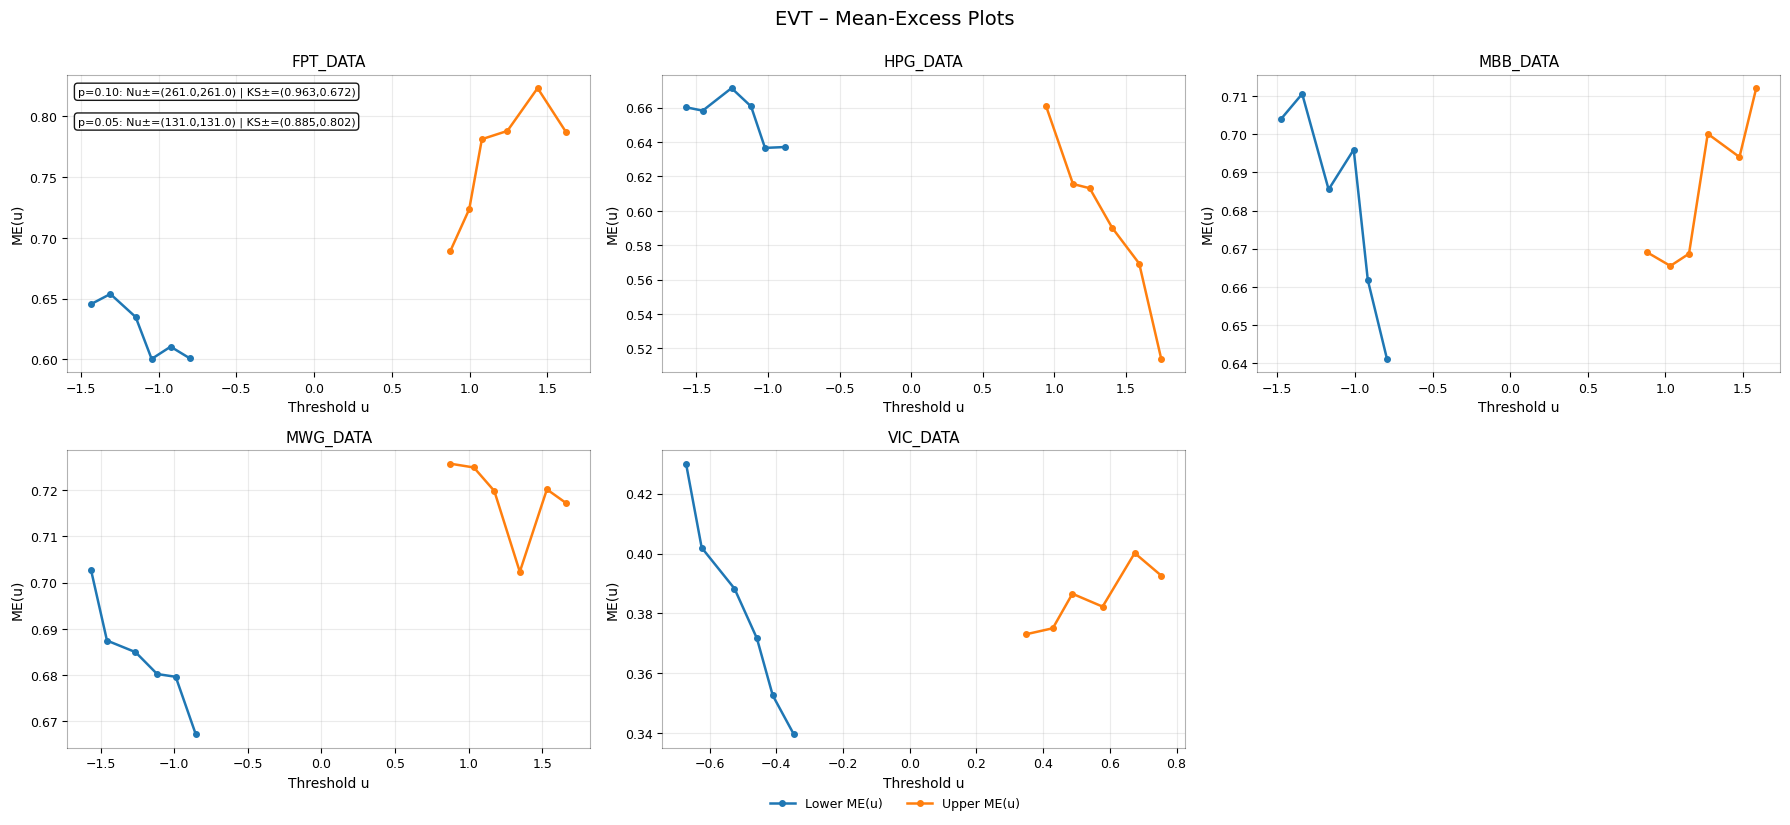

In [87]:
plot_mean_excess_grid(std_residuals_dict, p_grid=(0.15,0.12,0.10,0.08,0.06,0.05), min_n=30, cols=3)

**Quan sát theo mã:**

- **FPT**:
  - Upper-tail tăng & khá tuyến tính ⇒ đuôi phải nặng.
  - Lower-tail giảm nhẹ ⇒ đuôi trái ngắn.
  - Hộp chú thích cho thấy tại $p=10\%$ và $5\%$, số mẫu vượt ngưỡng ($Nu+$) đủ lớn và KS+ p-value cao (>0.6) → fit GPD phía phải khá ổn.

- **HPG**:
  - Lower giảm và Upper giảm dần ⇒ đuôi tương đối ngắn, bất đối xứng không quá mạnh.

- **MBB**:
  - Upper tăng rõ (đuôi phải nặng), lower giảm (đuôi trái ngắn) ⇒ bất đối xứng nghiêng phải.

- **MWG**:
  - Cả hai phía gần phẳng/nhẹ cong ⇒ đuôi gần mũ, mỏng hơn các mã khác.

- **VIC**:
  - Upper tăng dốc ⇒ đuôi phải rất nặng.
  - Lower giảm ⇒ trái ngắn → phù hợp với rủi ro đuôi phải lớn đã thấy ở NIA.

**Kết luận ngắn:** ME-plots cho thấy bất đối xứng đuôi giữa trái–phải; FPT/MBB/VIC có đuôi phải nặng (rủi ro cực trị tăng ở lợi suất dương lớn), HPG/MWG mỏng hơn. Những đoạn ME(u) tăng tuyến tính là tín hiệu tốt để chọn ngưỡng EVT và khẳng định tính đuôi dày ở các mã nói trên.

### EVT – Parameter Stability ($\xi$ & $\beta$ theo $p$)

Ý nghĩa của việc quan sát độ ổn định của tham số ξ khi thay đổi ngưỡng (p) là để tìm ra ngưỡng phù hợp nhất để mô hình hóa dữ liệu cực trị.

- Nếu đường biểu diễn ξ ít dao động và ổn định, vùng ngưỡng đó là lý tưởng.
- Nếu đường ξ tăng/giảm đột ngột, ngưỡng đó không phù hợp.

Từ đó, ta có thể chọn một ngưỡng (p) mà tại đó tham số hình dạng ξ ổn định, giúp mô hình GPD đáng tin cậy hơn.

- ξ > 0: Đuôi dày (heavy-tailed), có nghĩa là những giá trị cực lớn vẫn có khả năng xuất hiện.
- ξ ≈ 0: Gần phân phối mũ, các giá trị cực lớn không quá phổ biến.
- ξ < 0: Đuôi ngắn (finite-tailed), dữ liệu có một điểm giới hạn và không thể vượt qua.

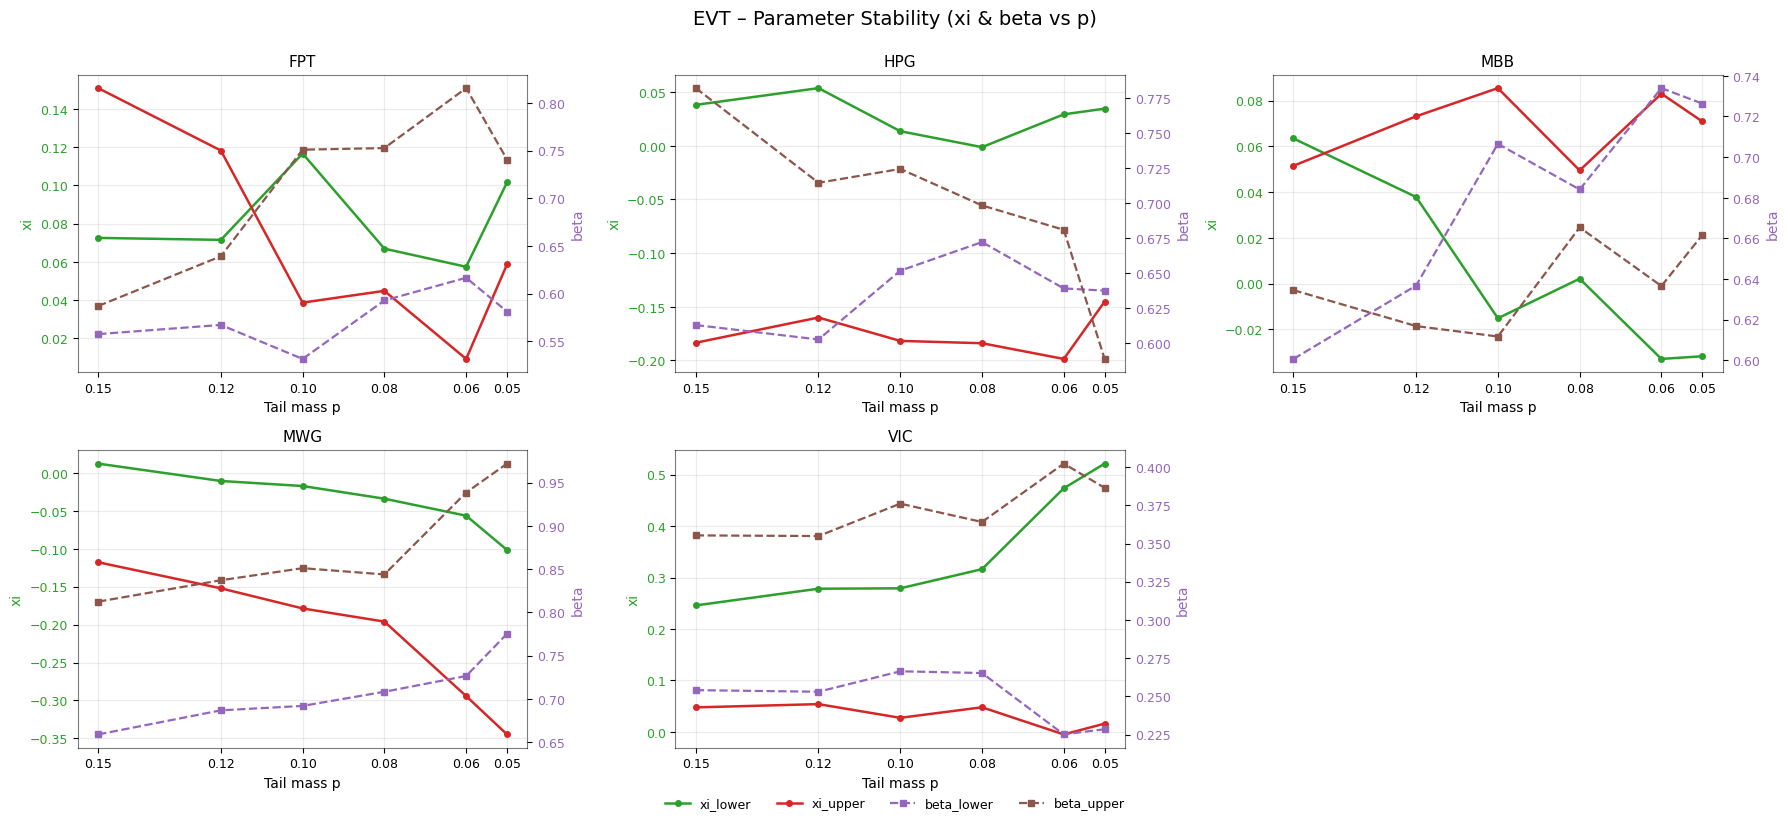

In [89]:
tickers = list(DATA_DICT.keys())
n = len(tickers)
cols = 3; rows = math.ceil(n/cols)
fig_st, axs = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), constrained_layout=True)
fig_st.suptitle("EVT – Parameter Stability (xi & beta vs p)", fontsize=14, y=0.995)

# Ensure axs is always 2D array for consistent indexing
if n == 1:
    axs = axs.reshape(1, -1)
elif rows == 1:
    axs = axs.reshape(1, -1)

for i, t in enumerate(tickers):
    df = tail_stats(DATA_DICT[t])
    
    # Calculate subplot position
    row = i // cols
    col = i % cols
    ax = axs[row, col]; ax2 = ax.twinx()

    # Clean ticker name by removing "_DATA" suffix  
    clean_ticker = t.replace("_DATA", "")

    # xi (trục trái)
    h3, = ax.plot(df["p"], df["xi_L"], "o-", lw=1.8, ms=4, color="#2ca02c", label="xi_lower")
    h4, = ax.plot(df["p"], df["xi_U"], "o-", lw=1.8, ms=4, color="#d62728", label="xi_upper")
    # beta (trục phải)
    h5, = ax2.plot(df["p"], df["beta_L"], "s--", lw=1.6, ms=4, color="#9467bd", label="beta_lower")
    h6, = ax2.plot(df["p"], df["beta_U"], "s--", lw=1.6, ms=4, color="#8c564b", label="beta_upper")

    ax.set_title(f"{clean_ticker}", fontsize=11)
    ax.set_xlabel("Tail mass p"); ax.set_ylabel("xi", color="#2ca02c")
    ax2.set_ylabel("beta", color="#9467bd")
    ax.invert_xaxis(); ax.grid(alpha=0.25)
    ax.tick_params(axis='y', labelcolor="#2ca02c", labelsize=9)
    ax2.tick_params(axis='y', labelcolor="#9467bd", labelsize=9)
    ax.set_xticks(P_GRID); ax.set_xticklabels([f"{p:.2f}" for p in P_GRID], fontsize=9)
    [sp.set_alpha(0.3) for sp in ax.spines.values()]
    [sp.set_alpha(0.3) for sp in ax2.spines.values()]

# Hide unused subplots
total_subplots = rows * cols
for j in range(n, total_subplots):
    row = j // cols
    col = j % cols
    axs[row, col].axis('off')

# legend chung (proxy)
proxies_st = [
    Line2D([0],[0], color="#2ca02c", marker="o", lw=1.8, ms=4, label="xi_lower"),
    Line2D([0],[0], color="#d62728", marker="o", lw=1.8, ms=4, label="xi_upper"),
    Line2D([0],[0], color="#9467bd", marker="s", lw=1.6, ms=4, ls="--", label="beta_lower"),
    Line2D([0],[0], color="#8c564b", marker="s", lw=1.6, ms=4, ls="--", label="beta_upper"),
]
fig_st.legend(proxies_st, [p.get_label() for p in proxies_st],
              loc="lower center", ncol=4, frameon=False, fontsize=9, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.08)

plt.tight_layout()
plt.show()


**Quan sát theo mã:**

- **FPT & MBB**:
  - $\xi_{upper}$ dương và khá ổn định (đuôi phải dày).
  - $\xi_{lower} \sim 0$/âm nhẹ (đuôi trái mỏng).
  - $\beta_{upper}$ nhích lên khi $p \downarrow$. Ổn nhất quanh $p \approx 0.08$–$0.10$.

- **HPG & MWG**:
  - $\xi$ gần 0 hoặc âm (đặc biệt upper của HPG và cả hai phía của MWG) ⇒ đuôi mỏng hơn các mã khác.

- **VIC**:
  - $\xi_{lower}$ cao và tăng khi $p \downarrow$ (đuôi trái rất dày).
  - $\xi_{upper}$ dương nhẹ ⇒ bất đối xứng nghiêng trái, rủi ro cực trị phía lỗ trội hơn.

### Diễn giải ngắn về bảng ngưỡng EVT và số mẫu vượt ngưỡng

Bảng trên cung cấp thông tin về ngưỡng EVT ($u_{lower}$, $u_{upper}$) và số mẫu vượt ngưỡng ($Nu_{lower}$, $Nu_{upper}$) cho từng mã cổ phiếu với tail mass $p = 0.1$.

Những ngưỡng này được chọn để đảm bảo số lượng mẫu vượt ngưỡng đủ lớn, hỗ trợ việc ước lượng chính xác các tham số GPD trong phân tích EVT.

In [92]:
import numpy as np, pandas as pd
DATA = std_residuals_dict
chosen_p = {'FPT_DATA':0.10,'HPG_DATA':0.10,'MBB_DATA':0.10,'MWG_DATA':0.10,'VIC_DATA':0.10}

rows=[]
for t,p in chosen_p.items():
    z = np.asarray(DATA[t], float)
    z = z[np.isfinite(z)]
    uL = np.nanpercentile(z, p*100)
    uU = np.nanpercentile(z, (1-p)*100)
    rows.append({'Ticker':t,'p':p,'u_lower':uL,'u_upper':uU,
                 'Nu_lower':int((z<uL).sum()), 'Nu_upper':int((z>uU).sum())})
print(pd.DataFrame(rows))

     Ticker    p   u_lower   u_upper  Nu_lower  Nu_upper
0  FPT_DATA  0.1 -1.045855  1.079413       261       261
1  HPG_DATA  0.1 -1.117803  1.248235       261       261
2  MBB_DATA  0.1 -1.008183  1.152070       261       261
3  MWG_DATA  0.1 -1.116250  1.173903       261       261
4  VIC_DATA  0.1 -0.458157  0.487522       261       261


### EVT – Tail Fit ở $p = 0.10$ ($Nu^+ = Nu^- = 261$)

**Ý nghĩa biểu đồ:** Histogram phần dư chuẩn hóa; hai đường đỏ đứt là ngưỡng $u^-$, $u^+$ tách 10% đuôi mỗi phía (các cột màu cam). Hộp chú thích hiển thị $KS_{upper,p}$ và $KS_{lower,p}$ để kiểm định GPD cho từng đuôi; $p$-value > Biểu đồ này là một Histogram (biểu đồ cột) của phần dư chuẩn hóa. Nó cho chúng ta thấy phân bố của các giá trị sau khi đã được mô hình hóa.

- Các cột màu cam: đại diện cho 10% dữ liệu ở hai phần đuôi (các giá trị rất lớn hoặc rất nhỏ) được tách ra để phân tích.
- Hai đường đỏ đứt: là các ngưỡng (u − ,u +) phân chia 10% đuôi này với phần còn lại của dữ liệu.

Ý nghĩa Kiểm định Thống kê

Phần chú thích hiển thị kết quả kiểm định Kolmogorov-Smirnov (KS) để đánh giá xem phân phối GPD có thực sự phù hợp với dữ liệu đuôi hay không.
- KS upper,p​ và KS lower,p: là các giá trị thống kê kiểm định cho đuôi trên và đuôi dưới.
- p-value > 0.05: Kết quả quan trọng nhất. Nếu giá trị này lớn hơn 0.05, điều đó có nghĩa là chúng ta không có đủ bằng chứng để bác bỏ giả thuyết rằng dữ liệu đuôi tuân theo phân phối GPD. Nói cách khác, mô hình GPD phù hợp để mô tả các giá trị cực trị của dữ liệu.

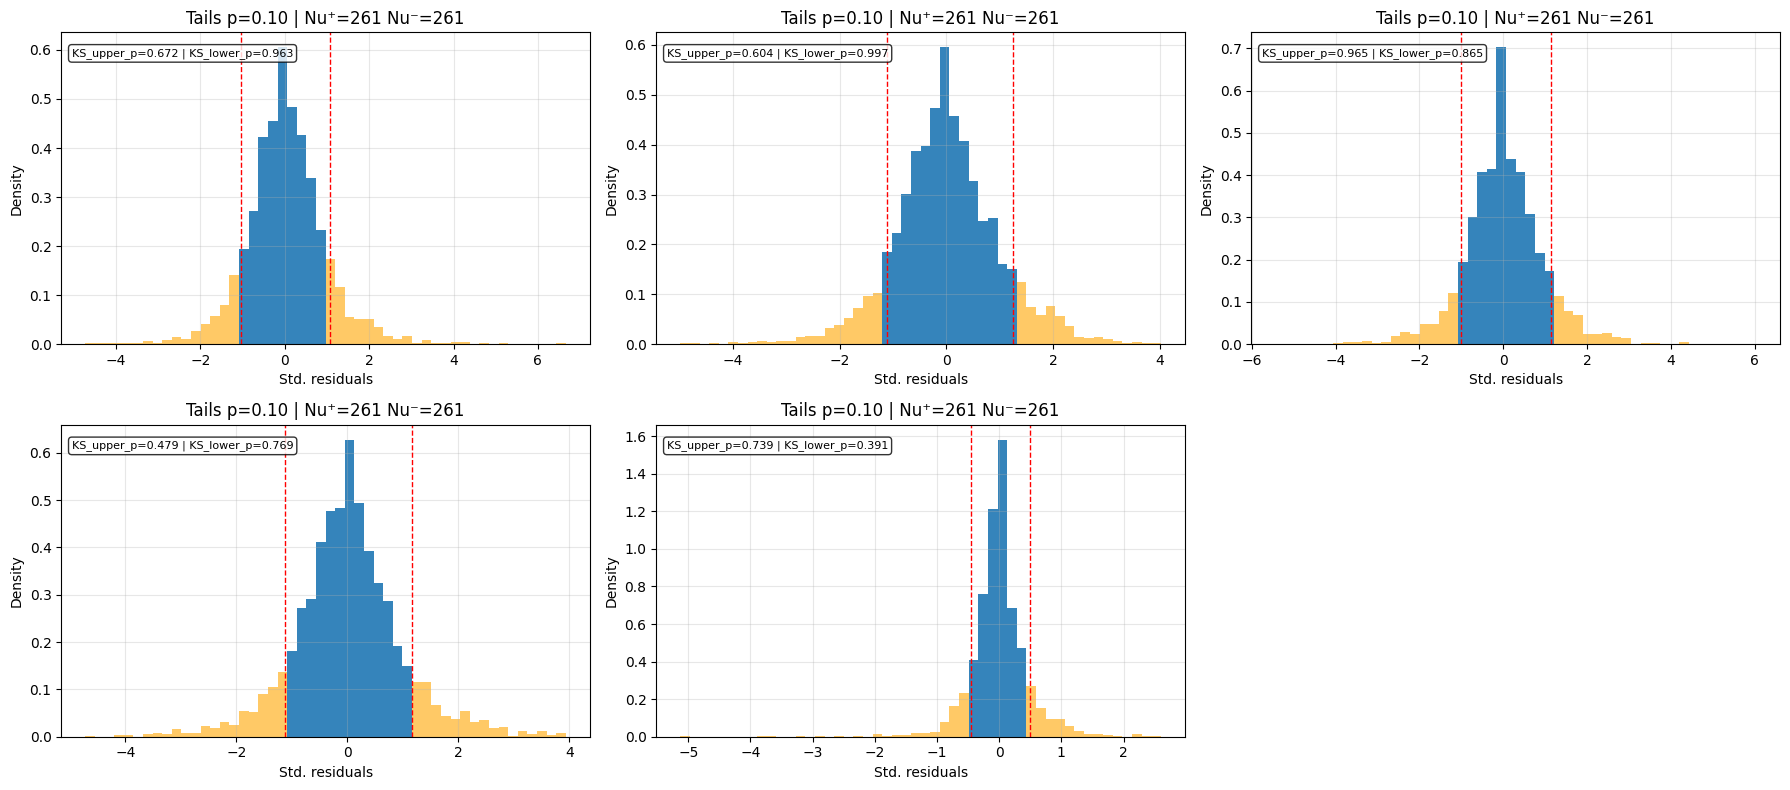

In [94]:
cols = 3; rows = math.ceil(len(std_residuals_dict)/cols)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.ravel()

for i, (ticker, residuals) in enumerate(std_residuals_dict.items()):
    # Fit GPD tails using existing function
    gpd_results = fit_gpd_tails(residuals, tail_prob=0.10)
    
    # Create diagnostic plots for this ticker
    gpd_tail_plots(residuals, gpd_results, ax_hist=axes[i])
    
    # Run diagnostic tests
    test_results = gpd_tail_tests(residuals, gpd_results)
    if test_results:
        # Format test results for display
        test_text = " | ".join([f"{test_name}={p_val:.3f}" for test_name, p_val in test_results.items()])
        axes[i].text(0.02, 0.95, test_text, transform=axes[i].transAxes, va='top',
                     bbox=dict(boxstyle='round', fc='white', alpha=0.8), fontsize=8)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Độ phù hợp theo mã:**
- **FPT** ($0.672 | 0.963$), **HPG** ($0.604 | 0.997$), **MBB** ($0.965 | 0.865$): Fit rất tốt ở cả hai đuôi.
- **MWG** ($0.479 | 0.769$): Đủ tốt, nhưng đuôi phải yếu hơn.
- **VIC** ($0.739 | 0.391$): Đủ điều kiện, song đuôi trái khớp yếu hơn các mã khác.

**Hàm ý bất đối xứng đuôi:** Hình dạng histogram cho thấy:
- **FPT/MBB** thiên phải (đuôi phải dày hơn).
- **HPG** hơi lệch trái.
- **MWG** đuôi mỏng hai phía.
- **VIC** thiên trái (nhiều quan sát cực trị phía lỗ).

Những kết quả này nhất quán với phân tích ME-plot và Stability trước đó, cung cấp thêm bằng chứng về đặc tính bất đối xứng đuôi của từng mã.

### Semi-parametric CDF (EVT blend, $p = 0.10$)

Đồ thị này cho chúng ta thấy sự khớp nhau giữa dữ liệu thực tế và mô hình lý thuyết của chúng ta.

- Đường xanh dương: Biểu diễn phân bố thực tế của dữ liệu.
- Đường đỏ: Biểu diễn mô hình chúng ta đã xây dựng, kết hợp hai phần:
- Phần giữa: Dùng dữ liệu thực tế.
- Phần đuôi: Dùng mô hình GPD (phân phối chuyên dùng cho các giá trị cực trị).
- Hai vạch cam: Là các ngưỡng, điểm phân chia giữa phần giữa và phần đuôi của dữ liệu.

Mục đích chính của đồ thị là để kiểm tra: Nếu đường màu đỏ và màu xanh dương trùng khớp nhau, điều đó có nghĩa là mô hình lai ghép của chúng ta rất phù hợp để mô tả toàn bộ phân bố dữ liệu, đặc biệt là ở những phần đuôi quan trọng.

SEMI-PARAMETRIC CDF PLOTS


SEMI-PARAMETRIC CDF PLOTS


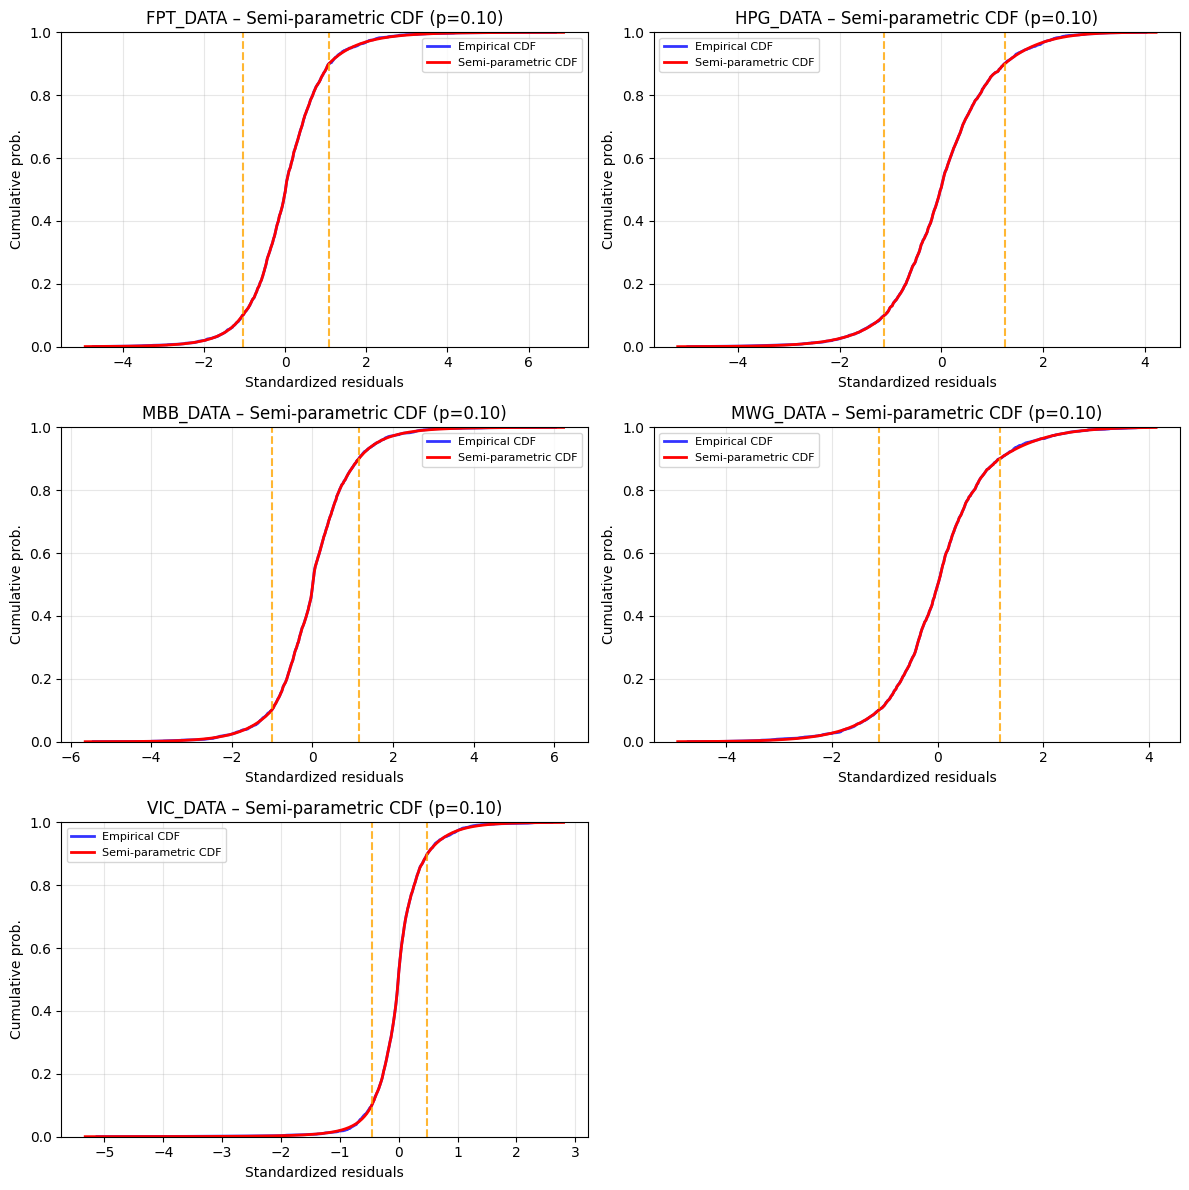

In [96]:
plot_semi_parametric_cdf(std_residuals_dict, p=0.1)

**Mức độ khớp:**
- Đường đỏ hầu như trùng đường xanh ở cả 5 mã ⇒ mô hình tái hiện tốt toàn bộ phân phối, đặc biệt phần đuôi.
- **FPT/MBB**: Khớp rất sát hai phía.
- **HPG/MWG**: Có khe nhỏ ở đuôi phải (đuôi mỏng hơn).
- **VIC**: Thể hiện đuôi trái dài hơn (đỏ lệch nhẹ phía âm).

**Hàm ý rủi ro:**
- Phù hợp để suy ra VaR/ES bằng CDF bán tham số.
- **VIC**: Có rủi ro đuôi trái nổi bật.
- **FPT/MBB**: Cho thấy đuôi phải dày hơn.
- **HPG/MWG**: Gần đối xứng và đuôi mỏng hơn các mã còn lại.